In [1]:
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Any, Union
from openpyxl import load_workbook


In [2]:
PATH_THEORY = "../../Data/Theory/MasterNuclei.xlsx"


In [3]:
# Matplotlib settings all LATEX
import matplotlib
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"], "size":18})
rc("text", usetex=True)

In [4]:
MPLHEP = False
if MPLHEP:
    import mplhep as hep
    plt.style.use(hep.style.CMS)

In [5]:
sys.path.append("../../nuclearpy_models")
from models.BE import dz_be, semf_be
from models.BE import dz_be, semf_be, sr_be
from utils.metrics import RegressionMetrics

In [6]:
exp_df = pd.read_csv('../../Data/Experimental/AME2020.csv', delimiter=',').query("Z>15").drop_duplicates(subset=['Z', 'N']).query("Z<=50")
exp_df["A"] = exp_df["Z"] + exp_df["N"]
exp_df = exp_df.query("Z <= 50")

In [7]:
exp_df["semf_pred"] = exp_df.apply(lambda x: semf_be(x["Z"], x["N"]), axis=1)
exp_df["dz_pred"] = exp_df.apply(lambda x: dz_be(x["Z"], x["N"]), axis=1)
exp_df["sr_pred"] = (exp_df.apply(lambda x: sr_be(x["Z"], x["N"]), axis=1))
exp_df["sr_error"] = exp_df["sr_pred"] - exp_df["BE"]
exp_df["dz_error"] = exp_df["dz_pred"] - exp_df["BE"]


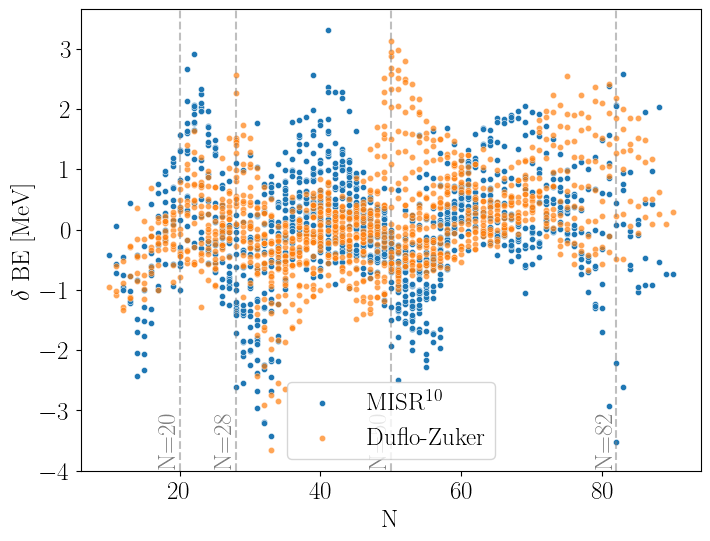

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(data=exp_df, x="N", y="sr_error", label=r"MISR$^{10}$", s=20)
sns.scatterplot(data=exp_df, x="N", y="dz_error", label="Duflo-Zuker", alpha=0.7, s=20)

# Labels for scientific notation
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.set(xlabel="N", ylabel=r"$\delta$ BE [MeV]")
# hlines on the magic numbers
magic_numbers = [20, 28, 50, 82]
for i in magic_numbers:
    ax.axvline(i, color="grey", linestyle="--", alpha=0.5)
    # Add vertical text to each line
    ax.text(i, -3.5, f"N={i}", rotation=90, verticalalignment="center", horizontalalignment="right", color="grey")
plt.savefig("sr_dz_error.pdf", bbox_inches="tight")

#### Loading test

In [9]:
PATH_THEORY = "../../Data/Theory/MasterNuclei.xlsx"
def get_sheets_name(filename):
    workbook = load_workbook(filename)
    return workbook.sheetnames


used_dfs = [
    "DD-ME2",
    # "SKMS",
    "HFB24",
    "NL3S",
    "UNEDF1",
]

th_datastes = get_sheets_name(PATH_THEORY)
th_datastes = [th_dataste for th_dataste in used_dfs if th_dataste != "AME2020"]

In [10]:
th_datastes

['DD-ME2', 'HFB24', 'NL3S', 'UNEDF1']

In [11]:
thdfs = {th_dataste: pd.read_excel(PATH_THEORY, sheet_name=th_dataste).query("Z >= 12 and N>=12").query("(N+Z)<250") for th_dataste in th_datastes}

In [12]:
def get_th_pred(Z, N, df_th):
    try:
        return df_th[(df_th["Z"] == Z) & (df_th["N"] == N)]["BE"].values[0]
    except:
        return np.nan

def patient_semf(Z, N):
    try:
        return dz_be(Z, N)
    except Exception as e:
        return np.nan

all_th_dfs = {}
all_th_in_exp = {}
for df_name in used_dfs:
    foo = thdfs.get(df_name).copy()
    foo["th_pred"] = foo.apply(lambda x: get_th_pred(x["Z"], x["N"], thdfs[df_name]), axis=1)
    foo["dz_pred"] = foo.apply(lambda x: patient_semf(x["Z"], x["N"]), axis=1)
    foo["dz_diff"] = foo.apply(lambda x: x["dz_pred"] - x["th_pred"], axis=1)
    foo["sr"] = foo.apply(lambda x: sr_be(x["Z"], x["N"]), axis=1)
    all_th_dfs[df_name] = foo.dropna()
    foo = exp_df.copy()
    foo["th_pred"] = foo.apply(lambda x: get_th_pred(x["Z"], x["N"], thdfs[df_name]), axis=1)
    foo["dz_pred"] = foo.apply(lambda x: patient_semf(x["Z"], x["N"]), axis=1)
    foo["dz_diff"] = foo.apply(lambda x: x["dz_pred"] - x["th_pred"], axis=1)
    foo["sr"] = foo.apply(lambda x: sr_be(x["Z"], x["N"]), axis=1)
    all_th_in_exp[df_name] = foo.dropna()


# Regression Metrics

In [13]:
exp_df

,BE,uBE,N,Z,eBE,A,semf_pred,dz_pred,sr_pred,sr_error,dz_error
259,169.650000,0.598000,10,16,1,26,162.579394,168.70228,169.221121,-0.428879,-0.947720
260,187.920000,0.405000,11,16,1,27,183.298519,186.82866,187.201623,-0.718377,-1.091340
261,209.406151,0.160000,12,16,0,28,206.236935,208.11504,208.454550,-0.951600,-1.291111
262,224.645095,0.013041,13,16,0,29,222.488411,224.35442,223.880109,-0.764986,-0.290675
263,243.681243,0.000207,14,16,0,30,241.264246,244.03080,242.847069,-0.834174,0.349557
...,...,...,...,...,...,...,...,...,...,...,...
1451,1114.792000,0.136000,86,50,1,136,1104.624532,1114.99318,1116.738171,1.946171,0.201180
1452,1116.824000,0.274000,87,50,1,137,1107.107441,1116.90956,1117.792235,0.968235,0.085560
1453,1120.284000,0.414000,88,50,1,138,1111.458113,1120.54494,1122.314097,2.030097,0.260940
1454,1122.147000,0.417000,89,50,1,139,1113.587007,1122.23132,1121.412697,-0.734303,0.084320


In [14]:
exp_df = exp_df.query("Z >= 12").query("Z<=50")

In [15]:
semf_metrics = RegressionMetrics(exp_df["BE"], exp_df["semf_pred"], "SEMF")()
dz_metrics = RegressionMetrics(exp_df["BE"], exp_df["dz_pred"], "DZ")()
dz_sr_metrics = RegressionMetrics(exp_df["BE"], exp_df["sr_pred"], "sr")()
results = pd.concat([semf_metrics, dz_metrics, dz_sr_metrics], axis=0)

for df_name in used_dfs:
   res = (RegressionMetrics(all_th_in_exp[df_name]["BE"], all_th_in_exp[df_name]["th_pred"], df_name)())
   results = pd.concat([results, res], axis=0)
all_th_dfs: Dict[str, pd.DataFrame]

results[["RMSE"]].sort_values(by="RMSE", inplace=False).rename(columns={"RMSE": "RMSE [MeV]"})

sr_rmse = results.reset_index().query("index == 'sr'")["RMSE"].values[0]
dz_rmse = results.reset_index().query("index == 'DZ'")["RMSE"].values[0]

In [16]:
results[["MAE", "RMSE"]]

,MAE,RMSE
SEMF,3.457480,4.842702
DZ,0.601646,0.825777
sr,0.730672,0.955452
DD-ME2,2.478863,2.825439
HFB24,0.543233,0.727646
NL3S,1.940749,2.427906
UNEDF1,1.745995,2.060744


In [17]:
def plot_isotope_be(
    df: pd.DataFrame,
    models: List[callable] = [dz_be, dz_be],
    model_names: List[str] = ["DZ", "SR"],
    fixed_z: int = 50,
    n_max = 120,
    ):

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    foo_df = df.query(f"Z=={fixed_z}")
    n_min = foo_df["N"].min()
    ns_in = foo_df["N"].values
    ns_out = np.arange(ns_in.max(), n_max)
    all_ns = np.concatenate([ns_in, ns_out])
    y = np.array([dz_be(fixed_z, n) for n in all_ns])
    ax.plot(foo_df["N"], foo_df["BE"]*0, label="Duflo Zuker", color="black", alpha=0.5)
    plt.errorbar(foo_df["N"], foo_df["BE"], yerr=foo_df["uBE"], fmt="o", label="Experiment", color="black")
    ax.hlines(0, n_min, n_max, color="black", linestyle="-")
    SEMF_error = foo_df["dz_pred"] - foo_df["BE"]
    sns.scatterplot(x="N", y=SEMF_error, data=foo_df, ax=ax, label=None, color="black")
    for i, (model, name) in enumerate(zip(models, model_names)):
        preds_in = np.array([model(fixed_z, n) for n in all_ns])
        errors = y - preds_in
        sns.scatterplot(x=all_ns, y=errors, ax=ax, color=f"C{i}", s=5)
        sns.lineplot(x=all_ns, y=errors, ax=ax, color=f"C{i}", linestyle=":", label=name)
    for j, df_name in enumerate(used_dfs):
        sns.scatterplot(x="N", y="dz_diff", data=all_th_dfs[df_name].query(f"Z=={fixed_z}"), ax=ax, s=10, color=f"C{j+2+i}")
        sns.lineplot(x="N", y="dz_diff", data=all_th_dfs[df_name].query(f"Z=={fixed_z}"), ax=ax, linestyle="--", label=df_name,  color=f"C{j+2+i}")

    ax.set(xlabel="N", ylabel=r"$\delta(BE)$ [MeV]", xlim=(n_min, n_max), ylim=(-10, 10))
    # put the legend in the left down corner
    ax.legend(fontsize=14)
    # Add annotations inside good looking boxes
    ax.annotate(f"Z={fixed_z}", xy=(0.5, 0.9), xycoords="axes fraction", fontsize=22)
    ax.legend(fontsize=14)
    plt.savefig(f"BE_{fixed_z}.pdf", bbox_inches="tight")

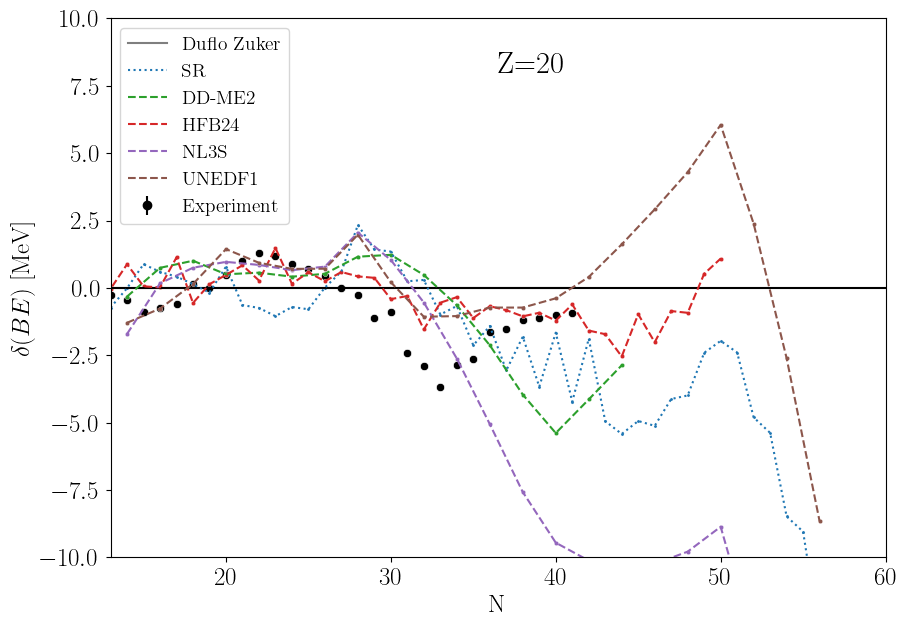

In [18]:
plot_isotope_be(exp_df, models=[sr_be],
                model_names = ["SR"],
                fixed_z=20, n_max=60)

# Unseen data

In [19]:
full_exp_df = pd.read_excel("../../Data/Theory/MasterNuclei.xlsx", sheet_name="AME2020").query("Z>=12").query("Z<=50")


In [20]:
%%capture
full_exp_df["sr_pred"] = full_exp_df.apply(lambda x: sr_be(x["Z"], x["N"]), axis=1)
full_exp_df["SEMF"] = full_exp_df.apply(lambda x: semf_be(x["Z"], x["N"]), axis=1)
full_exp_df["dz_pred"] = full_exp_df.apply(lambda x: dz_be(x["Z"], x["N"]), axis=1)

In [21]:
full_exp_df = full_exp_df.query("Z >= 20 and Z <= 50")

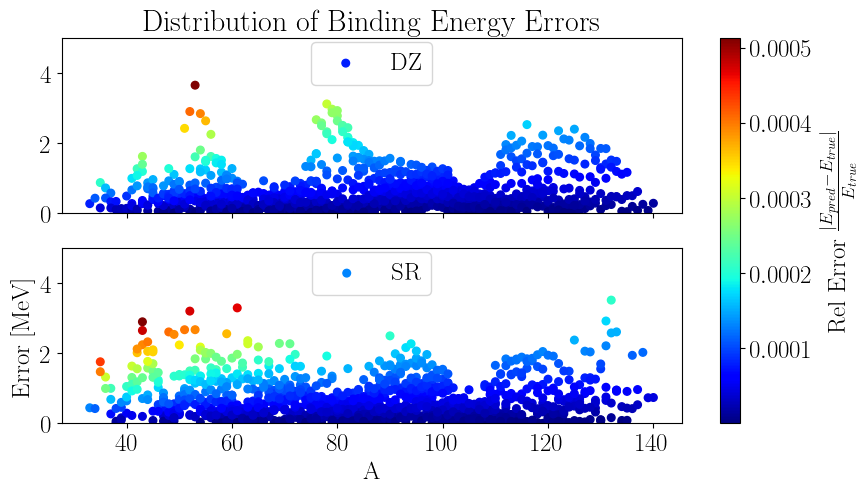

In [22]:
foo_full = full_exp_df.copy()
regr_error = np.abs((foo_full.sr_pred - foo_full.BE.values))
SEMF_error = np.abs((foo_full.SEMF - foo_full.BE.values))
dz_error = np.abs((foo_full.dz_pred - foo_full.BE.values))
max_error = np.max([regr_error, SEMF_error, dz_error])

A = foo_full["Z"] + foo_full["N"]
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
for i, (data, label) in enumerate(
    zip([dz_error, regr_error], ["DZ", "SR"])
):
    rel_error = np.abs(data / foo_full.BE.values)
    g = ax[i].scatter(A, data, c=rel_error / max_error, cmap="jet", s=30, label=label)
    # set location of legend
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
    ax[i].set(ylim=(0, 5))
ax[i].set_xlabel("A")
ax[1].set_ylabel("Error [MeV]", rotation=90)

ax[0].set_title("Distribution of Binding Energy Errors")
# Add a colorbar to the figure
ax[0].figure.colorbar(g, ax=ax, label = r"Rel Error $\frac{|E_{pred} - E_{true}|}{E_{true}}$")

# Smart ensemble of the models

In [25]:
import numpy as np

try:
    np.distutils.__config__.blas_opt_info = np.distutils.__config__.blas_ilp64_opt_info
except Exception:
    pass

In [49]:
import pymc as pm
import numpy as np

# Simulated data for illustration (replace these with your actual data)
model1_output = full_exp_df["sr_pred"].values
model2_output = full_exp_df["dz_pred"].values
N = full_exp_df["N"].values
Z = full_exp_df["Z"].values
y = full_exp_df["BE"].values

# Prepare input for the neural network (NN)
NZ = np.vstack([N, Z]).T

with pm.Model() as model:
    # Neural network architecture
    weights_NZ = pm.Normal('weights_NZ', 0, 1, shape=(2, 1))
    bias_NZ = pm.Normal('bias_NZ', 0, 1)

    # NN_output = tt.nnet.sigmoid(tt.dot(NZ, weights_NZ) + bias_NZ) # DEPROCIATED
    NN_output = pm.math.sigmoid(pm.math.dot(NZ, weights_NZ) + bias_NZ)

    # Ensemble prediction
    ensemble_pred = NN_output.flatten() * model1_output + (1 - NN_output.flatten()) * model2_output
    # Likelihood (data likelihood)
    y_obs = pm.Normal('y_obs', mu=ensemble_pred, sigma=1, observed=y)
    # Inference
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights_NZ, bias_NZ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


In [62]:
trace.posterior["weights_NZ"].mean(axis=0)

<xarray.DataArray 'weights_NZ' (draw: 1000, weights_NZ_dim_0: 2,
                                weights_NZ_dim_1: 1)>
array([[[ 0.17823909],
        [-0.27757309]],

       [[ 0.15836375],
        [-0.24689089]],

       [[ 0.19426494],
        [-0.30766468]],

       ...,

       [[ 0.23386146],
        [-0.39360462]],

       [[ 0.26663242],
        [-0.43118999]],

       [[ 0.25671134],
        [-0.41361833]]])
Coordinates:
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * weights_NZ_dim_0  (weights_NZ_dim_0) int64 0 1
  * weights_NZ_dim_1  (weights_NZ_dim_1) int64 0

In [75]:
def bayesian_ensemble_prediction(Z, N, model, trace):
    with model:
        NZ = np.vstack([Z, N]).T

        # Simulate or get model outputs for the given Z and N
        model1_output = sr_be(Z, N)
        model2_output = dz_be(Z, N)

        # Access the posterior samples
        weights_NZ_samples = trace.posterior['weights_NZ'].values
        bias_NZ_samples = trace.posterior['bias_NZ'].values

        # Generate ensemble predictions for all posterior samples
        ensemble_preds = []
        for weights, bias in zip(weights_NZ_samples.reshape(-1, 2), bias_NZ_samples.reshape(-1)):
            NN_output = 1 / (1 + np.exp(-np.dot(NZ, weights) - bias))
            ensemble_pred = NN_output * model1_output + (1 - NN_output) * model2_output
            ensemble_preds.append(ensemble_pred)

        ensemble_preds = np.array(ensemble_preds)

        # Calculate mean and standard deviation of ensemble predictions
        ensemble_mean = np.mean(ensemble_preds, axis=0)
        ensemble_std = np.std(ensemble_preds, axis=0)

        return ensemble_mean[0], ensemble_std[0]


In [76]:
bayesian_ensemble_prediction(19, 32, model, trace)

(417.02475721132674, 7.51886060787598e-05)

In [77]:
(sr_be(19, 32) + dz_be(19, 32)) / 2

417.0341807508885

In [80]:
def model_ensemble(Z, N):
    return bayesian_ensemble_prediction(Z, N, model, trace)[0]
# def model_ensemble(Z, N):
#     model_1_pred = dz_be(Z, N)
#     model_2_pred = sr_be(Z, N)
#     new_X = np.array([[model_1_pred, model_2_pred, N, Z]])
#     return model.predict(new_X)[0]

In [81]:
ensemble_pred = full_exp_df.apply(lambda x: model_ensemble(x["Z"], x["N"]), axis=1)
full_exp_df["ensemble_pred"] = ensemble_pred
full_exp_df["ensemble_error"] = full_exp_df["ensemble_pred"] - full_exp_df["BE"]

RMSE: 0.812, MAE: 0.587


<Axes: xlabel='N', ylabel='ensemble_error'>

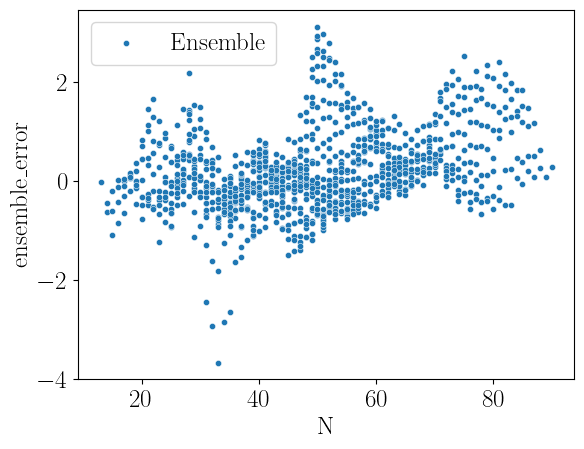

In [82]:
rmse, mae = np.sqrt(np.mean(full_exp_df["ensemble_error"]**2)), np.mean(np.abs(full_exp_df["ensemble_error"]))
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}")
sns.scatterplot(x="N", y="ensemble_error", data=full_exp_df, label="Ensemble", s=20)

RMSE: 0.640, MAE: 0.501


# Neutron Separation energies

In [90]:
sn_df = full_exp_df.copy().query("Z>=20")

In [91]:
def predict_sn(Z, N, model):
    return model(Z, N+1) - model(Z, N)

def experimental_sn(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "sn_exp"] = df[(df["Z"] == row["Z"]) & (df["N"] == row["N"]+1)]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "sn_exp"] = np.nan
    return df

def theory_sn(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z) & (th_df["N"] == N+1)]["BE"].values[0] - th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0]
    except Exception as e:
        # raise e
        return np.nan


In [92]:
sn_df["exp_sn"] = experimental_sn(sn_df)["sn_exp"]
sn_df["sr_sn"] = sn_df.apply(lambda x: predict_sn(x["Z"], x["N"], sr_be), axis=1)
sn_df["dz_sn"] = sn_df.apply(lambda x: predict_sn(x["Z"], x["N"], dz_be), axis=1)
# sn_df["theory_sn"] = sn_df.apply(lambda x: theory_sn(x["Z"], x["N"], full_exp_df), axis=1)
sn_df["ensemble_sn"] = sn_df.apply(lambda x: predict_sn(x["Z"], x["N"], model_ensemble), axis=1)

In [93]:
for th_name in used_dfs:
    sn_df[f"{th_name}_sn"] = sn_df.apply(lambda x: theory_sn(x["Z"], x["N"], thdfs[th_name]), axis=1)

In [94]:
def get_experimiental_unc_sn(Z, N, df):
    try:
        return df[(df["Z"] == Z) & (df["N"] == N+1)]["uBE"].values[0] + df[(df["Z"] == Z) & (df["N"] == N)]["uBE"].values[0]
    except:
        return np.nan

In [95]:
dz_rmse = np.sqrt(np.mean((sn_df["exp_sn"] - sn_df["dz_sn"])**2))
sr_rmse = np.sqrt(np.mean((sn_df["exp_sn"] - sn_df["sr_sn"])**2))
ensm_rmse = np.sqrt(np.mean((sn_df["exp_sn"] - sn_df["ensemble_sn"])**2))
print(f"SR RMSE: {sr_rmse}, DZ RMSE: {dz_rmse}, Ensemble RMSE: {ensm_rmse}")

SR RMSE: 0.585026450474013, DZ RMSE: 0.34450142556384655, Ensemble RMSE: 0.34379513901479175


In [ ]:
def plot_sn_energy(fixed_z, n_min, n_max):
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    foo_df = sn_df.query(f"Z=={fixed_z} and N>={n_min} and N<={n_max}")
    # predict for models
    pres = [predict_sn(fixed_z, n, sr_be) for n in range(n_min, n_max+1)]
    predz = [predict_sn(fixed_z, n, dz_be) for n in range(n_min, n_max+1)]
    # experimental
    unc = [get_experimiental_unc_sn(fixed_z, n, full_exp_df) for n in range(n_min, n_max+1)]
    # For uncertainty


    # sns.scatterplot(x="N", y="exp_sn", data=foo_df, label="AME2016", color="black", marker="x")
    plt.errorbar(range(n_min, n_max+1), foo_df["exp_sn"], yerr=unc, label="AME2016", color="black", alpha=0.8, fmt='o',  ecolor="black", elinewidth=1, capsize=2, capthick=1.5)
    sns.lineplot(x="N", y="exp_sn", data=foo_df, color="black")
    # For sr
    sns.scatterplot(x=range(n_min, n_max+1), y=pres, label="SR", color="red", s=30)
    # For dz
    sns.scatterplot(x=range(n_min, n_max+1), y=predz, label="Duflo Zucker", color="blue")
    # sns.scatterplot(x="N", y="dz_sn", data=foo_df, label="DZ", color="blue")
    sns.scatterplot(x="N", y="UNEDF1_sn", data=foo_df, label="UNEDF1", color="green")
    # sns.scatterplot(x="N", y="ensemble_sn", data=foo_df, label="Ensemble", color="orange")
    ax.set(xlabel="N", ylabel=r"$S_n$ [MeV]", title=f"Separation Energy, $Z = {fixed_z}$")
    ax.legend(fontsize=22)
    # Add an annotation for the RMSE with a box around it
    ax.annotate(f"RMSE\nMISR: {sr_rmse:.2f} MeV\nDuflo-Zucker: {dz_rmse:.2f} MeV", xy=(0.5, 0.5), xycoords='axes fraction', fontsize=22, bbox=dict(facecolor='white', alpha=0.5))

ValueError: 'x' and 'y' must have the same size

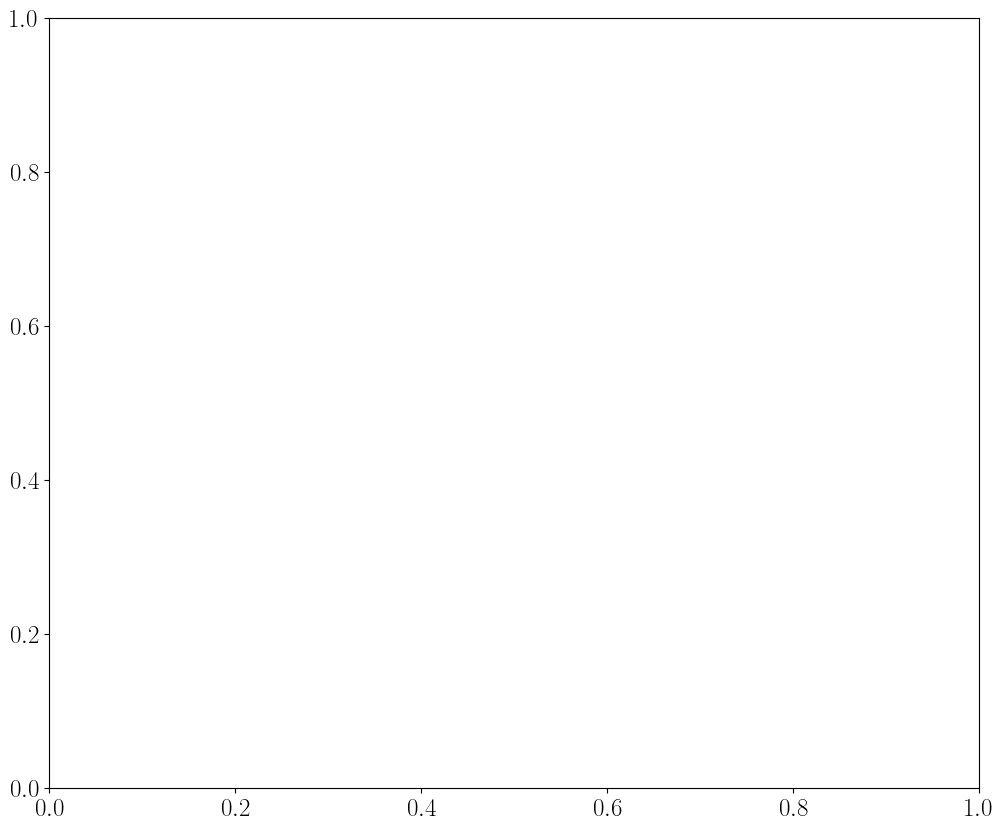

In [ ]:
plot_sn_energy(18, 15, 25)

In [ ]:
# plot_sn_energy(20, 20, 45)

# Proton Separation energies


In [ ]:
sp_df = full_exp_df.copy().query("Z>=12")
def predict_sp(Z, N, model):
    return model(Z, N) - model(Z-1, N)

def experimental_sp(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "sp_exp"] = -df[(df["Z"] == row["Z"]-1) & (df["N"] == row["N"])]["BE"].values[0] + row["BE"]
        except:
            df.at[i, "sp_exp"] = np.nan
    return df

def theory_sp(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0] - th_df[(th_df["Z"] == Z-1) & (th_df["N"] == N)]["BE"].values[0]
    except:
        return np.nan


In [ ]:
sp_df["exp_sp"] = experimental_sp(sp_df)["sp_exp"]
sp_df["sr_sp"] = sp_df.apply(lambda x: predict_sp(x["Z"], x["N"], sr_be), axis=1)
sp_df["dz_sp"] = sp_df.apply(lambda x: predict_sp(x["Z"], x["N"], dz_be), axis=1)
sn_df["ensemble_sp"] = sn_df.apply(lambda x: predict_sp(x["Z"], x["N"], model_ensemble), axis=1)

In [ ]:
for th_name in used_dfs:
    sp_df[f"{th_name}_sp"] = sp_df.apply(lambda x: theory_sp(x["Z"], x["N"], thdfs[th_name]), axis=1)

In [ ]:
sp_df

,BE,uBE,N,Z,eBE,sr_pred,SEMF,dz_pred,ensemble_pred,ensemble_error,sp_exp,exp_sp,sr_sp,dz_sp,DD-ME2_sp,SKMS_sp,HFB24_sp,NL3S_sp,UNEDF1_sp
188,132.237000,0.609000,8,13,1,134.087972,124.515268,131.33243,132.710201,0.473201,NaN,NaN,-3.198224,-2.37897,NaN,NaN,NaN,NaN,NaN
189,149.204000,0.396000,9,13,1,149.368842,144.736749,148.71581,149.042326,-0.161674,NaN,NaN,-0.009905,-0.58497,NaN,NaN,NaN,NaN,NaN
190,168.721733,0.000345,10,13,0,169.841179,167.152647,168.18219,169.011684,0.289952,NaN,NaN,0.781502,0.34003,NaN,NaN,NaN,NaN,NaN
191,183.589934,0.000228,11,13,0,184.857625,182.007032,182.52157,183.689598,0.099663,NaN,NaN,2.498658,1.87903,NaN,NaN,NaN,NaN,NaN
192,200.528415,0.000065,12,13,0,201.863022,199.516409,199.89295,200.877986,0.349571,NaN,NaN,2.911524,2.96403,NaN,4.002596,1.008985,NaN,3.488684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,1114.792000,0.136000,86,50,1,1116.738171,1104.624532,1114.99318,1115.865675,1.073675,16.432,16.432,17.940463,16.12303,NaN,15.967329,15.688985,NaN,16.524787
1452,1116.824000,0.274000,87,50,1,1117.792235,1107.107441,1116.90956,1117.350897,0.526897,16.448,16.448,16.992878,16.02703,NaN,16.186229,15.688985,NaN,16.721968
1453,1120.284000,0.414000,88,50,1,1122.314097,1111.458113,1120.54494,1121.429519,1.145519,17.023,17.023,19.586854,16.65703,NaN,16.404804,16.278985,NaN,16.936395
1454,1122.147000,0.417000,89,50,1,1121.412697,1113.587007,1122.23132,1121.822009,-0.324991,NaN,NaN,16.247321,16.55603,NaN,16.603960,16.238984,NaN,17.103068


In [ ]:
def plot_sp_energy(fixed_n, z_min, z_max):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    foo_df = sp_df.query(f"N=={fixed_n} and Z>={z_min} and Z<={z_max}")
    # predict for models
    pres = [predict_sp(z, fixed_n, sr_be) for z in range(z_min, z_max+1)]
    predz = [predict_sp(z, fixed_n, dz_be) for z in range(z_min, z_max+1)]
    sns.scatterplot(x="Z", y="exp_sp", data=foo_df, label="AME2016", color="black", marker="x")
    sns.lineplot(x="Z", y="exp_sp", data=foo_df, color="black")
    # For sr
    sns.scatterplot(x=range(z_min, z_max+1), y=pres, label="SR", color="red")
    # For dz
    sns.scatterplot(x=range(z_min, z_max+1), y=predz, label="Dulfo-Zuker", color="blue")
    # sns.scatterplot(x="N", y="dz_sn", data=foo_df, label="DZ", color="blue")
    sns.scatterplot(x="Z", y="UNEDF1_sp", data=foo_df, label="UNEDF0", color="green")
    # sns.scatterplot(x="N", y="ensemble_sn", data=foo_df, label="Ensemble", color="orange")
    ax.set(xlabel="Z", ylabel=r"$S_p$ [MeV]", title=f"$N = {fixed_n}$, $Z = {z_min}-{z_max}$")
    ax.legend(fontsize=14)


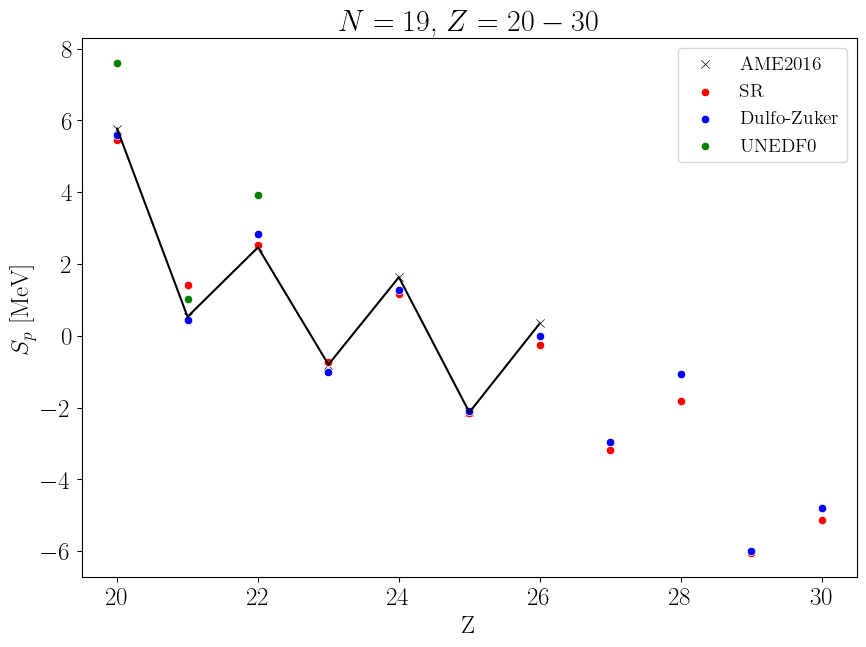

In [ ]:
plot_sp_energy(19, 20, 30)

# Two proton separation energies


In [ ]:
def predict_s2p(Z, N, model):
    return model(Z, N) - model(Z-2, N)

def experimental_s2p(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "s2p_exp"] = -df[(df["Z"] == row["Z"]-2) & (df["N"] == row["N"])]["BE"].values[0] + row["BE"]
        except:
            df.at[i, "s2p_exp"] = np.nan
    return df

# Two proton separation energies


In [ ]:
def predict_s2n(Z, N, model):
    return  model(Z, N+2) - model(Z, N)

def experimental_s2n(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "s2n_exp"] = df[(df["Z"] == row["Z"]) & (df["N"] == row["N"]+2)]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "s2n_exp"] = np.nan
    return df



In [ ]:
s2n_df = full_exp_df.copy().query("Z>=12")
s2n_df["exp_s2n"] = experimental_s2n(s2n_df)["s2n_exp"]
s2n_df["sr_s2n"] = s2n_df.apply(lambda x: predict_s2n(x["Z"], x["N"], sr_be), axis=1)
s2n_df["dz_s2n"] = s2n_df.apply(lambda x: predict_s2n(x["Z"], x["N"], dz_be), axis=1)

Replicating the result from the nature:


In [ ]:
def plot_s2n(fixed_z, n_min, n_max):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    foo_df = s2n_df.query(f"Z=={fixed_z} and N>={n_min} and N<={n_max}")
    # predict for models
    pres = [predict_s2n(fixed_z, n, sr_be) for n in range(n_min, n_max+1)]
    predz = [predict_s2n(fixed_z, n, dz_be) for n in range(n_min, n_max+1)]
    sns.scatterplot(x="N", y="exp_s2n", data=foo_df, label="AME2016", color="black", marker="x")
    sns.lineplot(x="N", y="exp_s2n", data=foo_df, color="black")
    # For sr
    sns.scatterplot(x=range(n_min, n_max+1), y=pres, label="SR", color="red")
    # For dz
    sns.scatterplot(x=range(n_min, n_max+1), y=predz, label="DZ", color="blue")
    # sns.scatterplot(x="N", y="dz_sn", data=foo_df, label="DZ", color="blue")
    # sns.scatterplot(x="N", y="UNEDF0_s2n", data=foo_df, label="UNEDF0", color="green")
    # sns.scatterplot(x="N", y="ensemble_sn", data=foo_df, label="Ensemble", color="orange")
    ax.set(xlabel="N", ylabel=r"$S_{2n}$ [MeV]", title=f"$Z = {fixed_z}$, $N = {n_min}-{n_max}$")
    ax.legend(fontsize=14)



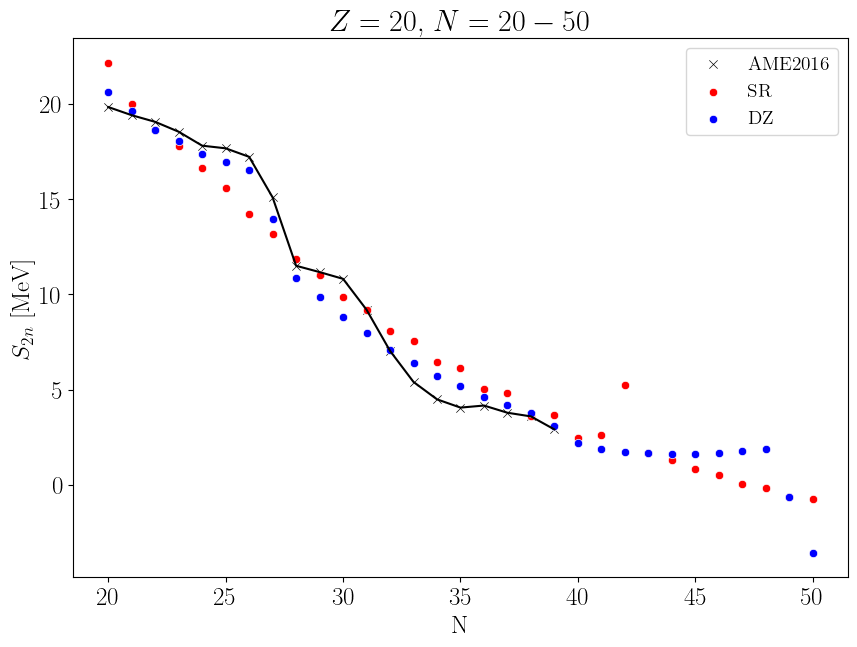

In [ ]:
plot_s2n(20, 20, 50)